Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---


# Model Interpretation 2

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make a Shapley force plot to explain at least 1 individual prediction.
- [ ] Share at least 1 visualization (of any type) on Slack.

But, if you aren't ready to make a Shapley force plot with your own dataset today, that's okay. You can practice this objective with another dataset instead. You may choose any dataset you've worked with previously.

## Stretch Goals
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!


## Links
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [2]:
%%capture
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_absolute_error
import category_encoders as ce
from sklearn.impute import SimpleImputer
import pickle

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    #import PKL Dataset ready for exploration 
    infile = open("/Users/user/Documents/GitHub/MIR/Spotify/master_list2.pkl",'rb')
    master_list2 = pickle.load(infile)

In [3]:
pd.options.display.max_colwidth = 200
description = pd.read_csv("/Users/user/Documents/GitHub/MIR/Spotify/feature_description.csv")
description.dropna(how="all")

Field   \
1                         session_id    
3                   session_position    
5                     session_length    
7                     track_id_clean    
9                             skip_1    
11                            skip_2    
13                            skip_3    
15                       not_skipped    
17                    context_switch    
19              no_pause_before_play    
21           short_pause_before_play    
23            long_pause_before_play    
25      hist_user_behavior_n_seekfwd    
27     hist_user_behavior_n_seekback    
29     hist_user_behavior_is_shuffle    
31                       hour_of_day    
33                              date    
35                           premium    
37                      context_type    
39   hist_user_behavior_reason_start    
41     hist_user_behavior_reason_end    
44                          duration    
46                      release_year    
48            us_popularity_estimate    
50                      acousticness    
52                     beat_strength    
54                        bounciness    
56                      danceability    
58                    dyn_range_mean    
60                            energy    
62                          flatness    
64                  instrumentalness    
66                               key    
68                          liveness    
70                          loudness    
72                         mechanism    
74                              mode    
76                          organism    
78                       speechiness    
80                             tempo    
82                    time_signature    
84                           valence    
86                 acoustic_vector_0    
88                 acoustic_vector_1    
90                 acoustic_vector_2    
92                 acoustic_vector_3    
94                 acoustic_vector_4    
96                 acoustic_vector_5    
98                 acoustic_vector_6    
100                acoustic_vector_7    

                                                                                                                                                                           Values   
1                                                                    E.g. _65_283174c5-551c-4c1b-954b-cb60ffcc2aec - unique identifier for the session that this row is a part of   
3                                                                                                                                         {1-20} - position of row within session   
5                                                                                                                                             {10-20} - number of rows in session   
7                   E.g. _t_13d34e4b-dc9b-4535-963d-419afa8332ec - unique identifier for the track played. This is linked with track_id in the track features and metadata table.   
9                                                                                                                    Boolean indicating if the track was only played very briefly   
11                                                                                                                        Boolean indicating if the track was only played briefly   
13                                                                                                                             Boolean indicating if most of the track was played   
15                                                                                                                   Boolean indicating that the track was played in its entirety   
17   Boolean indicating if the user changed context between the previous row and the current row. This could for example occur if the user switched from one playlist to another.   
19                                                                                 Boolean indicating if there was no pause betwe

# Started Over Again: GOOD NEWS! Finalized non-leaky feature list!

In [ ]:
#Baseline measurement is 49% for songs played in full 

In [184]:
master_list2["skip_2"].value_counts(normalize=True)

True     0.507247
False    0.492753
Name: skip_2, dtype: float64

In [178]:
#removing features likely to leak 

features = [ 
       'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence']

target = 'skip_2'
drop = ['track_id','skip_1', 'skip_3', 'no_pause_before_play','short_pause_before_play', 'long_pause_before_play','hist_user_behavior_reason_end','hist_user_behavior_n_seekfwd', 
       'hist_user_behavior_n_seekback','hist_user_behavior_reason_start','context_switch','hist_user_behavior_is_shuffle','not_skipped','session_position','session_length','hour_of_day','context_type']

X = master_list2[features]
y = master_list2[target]

In [179]:
#first split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [180]:
#second plit for validation holdout

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [181]:
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5403345006065936


In [182]:
k = 3
scores = cross_val_score(pipeline, X_val, y_val, cv=k, 
                         scoring='recall')
print(f'Recall for {k} folds :', scores)

Recall for 3 folds : [0.53473095 0.5454174  0.53672796]


In [186]:
#validate set recall score:

scores.mean()

0.538958770513353

In [189]:
y_pred = pipeline.predict(X_val)

In [190]:
#recall is the correct metric, because it reveals how many relevant items were selected. 

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print("Accuracy:",accuracy_score(y_val, y_pred))
print("ROC:",roc_auc_score(y_val, y_pred))
print("Recall:",recall_score(y_val, y_pred))
print("Precision:",precision_score(y_val, y_pred))

Accuracy: 0.5403345006065936
ROC: 0.5399977355977533
Recall: 0.569771705763408
Precision: 0.5433681370834791


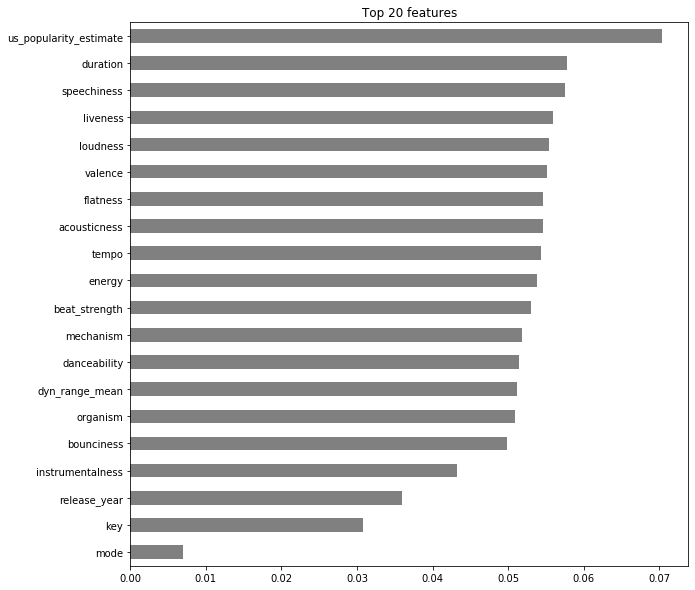

In [183]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_val.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [193]:
transformer = make_pipeline(
    ce.TargetEncoder()
)

X_train_transformed = transformer.fit_transform(X_train,y_train)
X_val_transformed = transformer.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [194]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='recall', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [195]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

release_year              0.009995
us_popularity_estimate    0.005124
speechiness               0.004307
instrumentalness          0.003666
dyn_range_mean            0.001878
bounciness                0.001494
duration                  0.001337
loudness                  0.001051
mechanism                 0.001025
energy                    0.000950
valence                   0.000559
flatness                  0.000538
beat_strength             0.000401
organism                  0.000280
danceability              0.000242
mode                      0.000225
tempo                     0.000177
key                       0.000053
liveness                  0.000040
time_signature           -0.000076
acousticness             -0.000161
dtype: float64

In [196]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

In [197]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

print('Shape after removing features:', X_train.shape)

Shape after removing features: (755033, 19)


In [199]:
X_val = X_val[features]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print("Recall:",recall_score(y_val, y_pred))

Recall: 0.5696774125954718


In [200]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print("Recall:",recall_score(y_val, y_pred))

Recall: 0.7206198204239002


In [201]:
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.5380882500966842


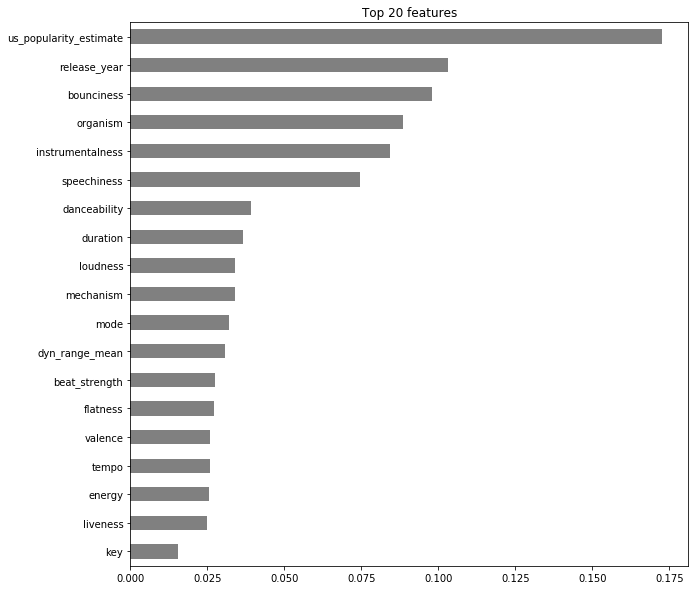

In [202]:
# Get feature importances
rf = pipeline.named_steps['xgbclassifier']
importances = pd.Series(rf.feature_importances_, X_val.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [203]:
encoder = ce.TargetEncoder()
X_train_encoded = encoder.fit_transform(X_train,y_train)
X_val_encoded = encoder.transform(X_val)

X_train.shape, X_val.shape, X_train_encoded.shape, X_val_encoded.shape

((755033, 19), (188759, 19), (755033, 19), (188759, 19))

In [210]:
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model = XGBClassifier(
    n_estimators=1000, # <= 1000 trees, depends on early stopping
    max_depth=7,       # try deeper trees because of high cardinality categoricals
    learning_rate=0.1, # try higher learning rate
    n_jobs=-1
)

model.fit(X_train_encoded, y_train, eval_set=eval_set, 
          eval_metric='error', early_stopping_rounds=50)

[0]	validation_0-error:0.462739	validation_1-error:0.465896
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.461381	validation_1-error:0.465165
[2]	validation_0-error:0.460519	validation_1-error:0.463596
[3]	validation_0-error:0.459654	validation_1-error:0.463014
[4]	validation_0-error:0.459408	validation_1-error:0.462929
[5]	validation_0-error:0.458813	validation_1-error:0.463146
[6]	validation_0-error:0.458596	validation_1-error:0.463109
[7]	validation_0-error:0.45811	validation_1-error:0.462627
[8]	validation_0-error:0.457804	validation_1-error:0.46286
[9]	validation_0-error:0.457314	validation_1-error:0.462161
[10]	validation_0-error:0.456826	validation_1-error:0.461695
[11]	validation_0-error:0.456298	validation_1-error:0.461128
[12]	validation_0-error:0.455987	validation_1-error:0.461239
[13]	validation_0-error:0.455558	validation_1-error:0.4609

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

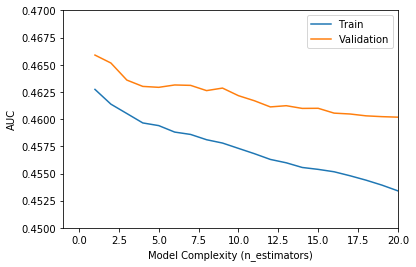

In [215]:
results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('AUC')
plt.xlabel('Model Complexity (n_estimators)')
plt.ylim((0.45, 0.47)) # Zoom in
plt.xlim((-1, 20)) # Zoom in
plt.legend();

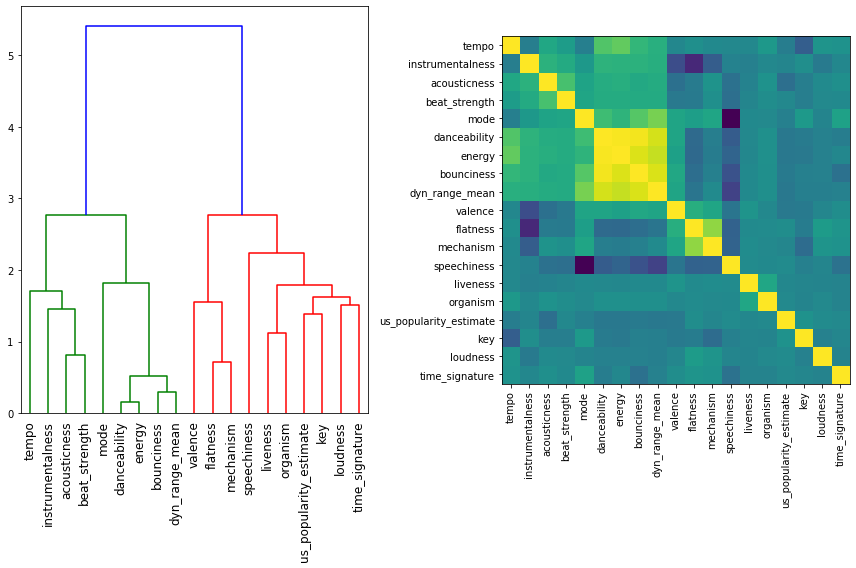

In [290]:
#Multicollinear Feature Visualization - Very Nice little visualization for Project 

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=master_list2.columns, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

In [237]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.TargetEncoder(), 
    XGBClassifier(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting recall', recall_score(y_val, y_pred))

Gradient Boosting recall 0.7005668067094828


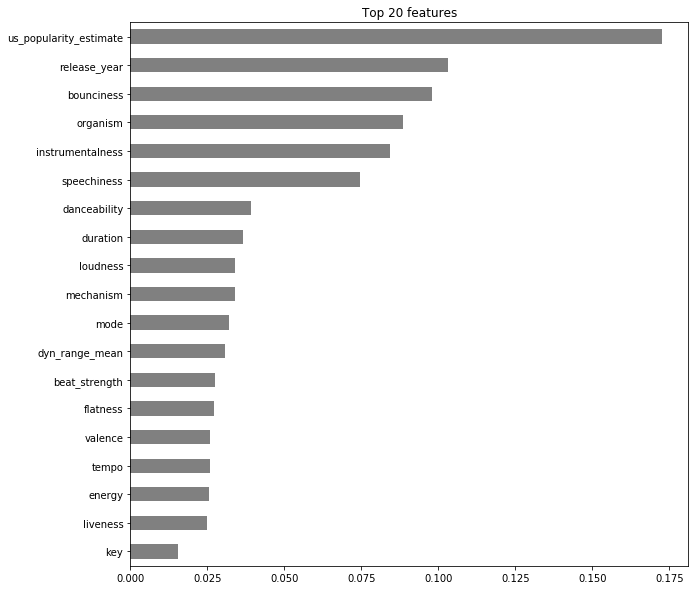

In [261]:
# Get feature importances
rf = pipeline.named_steps['xgbclassifier']
importances = pd.Series(rf.feature_importances_, X_val.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

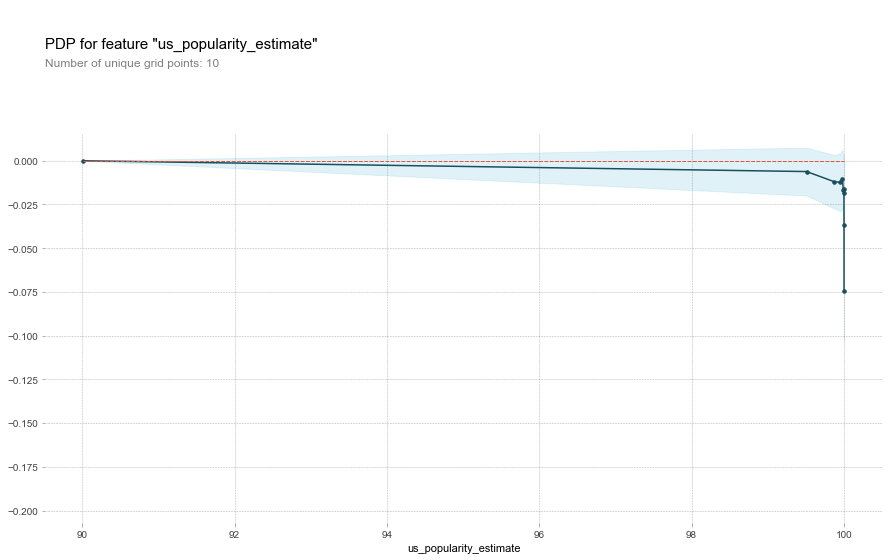

In [267]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

#this reveals a directly positively linear relationship between length of session and probability that track was more than partially played 

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'us_popularity_estimate'

isolated = pdp_isolate(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);
# plt.xlim((99.5, 100)) # Zoom in
# plt.ylim((-.075, .1)) # Zoom in

In [272]:
master_list2.groupby(["us_popularity_estimate"])["skip_2"].mean()

us_popularity_estimate
90.008624    0.000000
90.010777    0.500000
90.011538    1.000000
90.037740    1.000000
90.044730    1.000000
90.053970    0.000000
90.054665    1.000000
90.056551    0.000000
90.060272    0.000000
90.068629    0.368421
90.075434    1.000000
90.080302    0.666667
90.081647    0.000000
90.084174    1.000000
90.087546    0.280000
90.090882    0.000000
90.092434    1.000000
90.096240    1.000000
90.099199    0.000000
90.105739    0.666667
90.108007    1.000000
90.109510    0.473684
90.110742    1.000000
90.112758    1.000000
90.113287    0.000000
90.115685    0.000000
90.116074    0.000000
90.116430    1.000000
90.119173    1.000000
90.127529    1.000000
               ...   
99.999784    0.427614
99.999786    0.490677
99.999802    0.533056
99.999821    0.373016
99.999825    0.477569
99.999826    0.530500
99.999834    0.502668
99.999838    0.527984
99.999844    0.286853
99.999849    0.450314
99.999857    0.467666
99.999868    0.451995
99.999871    0.538160
99.999883

In [273]:
X_train["us_popularity_estimate"].value_counts()

99.999987    12417
99.999982     6629
99.999997     5956
99.999931     5683
99.999857     5353
99.999583     5138
99.999693     4757
99.999746     4297
99.999725     4143
99.999973     3407
99.999710     3263
99.998359     3197
99.998546     3072
99.999976     2948
99.999992     2868
99.999989     2753
99.997312     2725
99.998810     2591
99.998495     2502
99.999886     2490
99.999912     2461
99.998760     2257
99.999849     2072
99.996897     2004
97.270832     1921
99.998868     1882
99.999727     1866
99.999656     1764
99.999743     1763
99.999802     1539
             ...  
98.303886        1
98.782626        1
99.239457        1
98.443189        1
97.188411        1
99.414234        1
99.853387        1
99.384133        1
99.653672        1
99.474812        1
97.771237        1
98.273959        1
98.765211        1
99.736984        1
99.112638        1
99.791703        1
97.933065        1
99.601082        1
98.061882        1
99.419847        1
99.799598        1
99.885857   

In [239]:
example = X_val.iloc[[0]]
example2 = X_val.iloc[[2]]

pd.concat([example, example2])

duration  release_year  us_popularity_estimate  beat_strength  \
865659   229.026672          2018               99.989460       0.539049   
1024397  194.741226          2018               99.932376       0.497585   

         bounciness  danceability  dyn_range_mean    energy  flatness  \
865659     0.554028      0.649553        8.263687  0.905567  0.947092   
1024397    0.474605      0.678826        7.153678  0.749636  1.016342   

         instrumentalness  key  liveness  loudness  mechanism   mode  \
865659       1.671728e-07    0  0.165505    -5.284   0.458955  major   
1024397      4.992139e-06    6  0.198020    -6.307   0.744505  major   

         organism  speechiness       tempo   valence  
865659   0.382659     0.229089   81.994003  0.579144  
1024397  0.185090     0.031449  130.020996  0.499382

# Creating Shapley Plot

In [251]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.535151	validation_1-auc:0.535336
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.535738	validation_1-auc:0.535883
[2]	validation_0-auc:0.535642	validation_1-auc:0.535844
[3]	validation_0-auc:0.538172	validation_1-auc:0.53804
[4]	validation_0-auc:0.538364	validation_1-auc:0.538267
[5]	validation_0-auc:0.541001	validation_1-auc:0.541208
[6]	validation_0-auc:0.542898	validation_1-auc:0.543329
[7]	validation_0-auc:0.54312	validation_1-auc:0.543692
[8]	validation_0-auc:0.543368	validation_1-auc:0.544115
[9]	validation_0-auc:0.544103	validation_1-auc:0.54458
[10]	validation_0-auc:0.544908	validation_1-auc:0.545175
[11]	validation_0-auc:0.545441	validation_1-auc:0.545863
[12]	validation_0-auc:0.546121	validation_1-auc:0.546595
[13]	validation_0-auc:0.546249	validation_1-auc:0.546673
[14]	validation_0-auc:0.546726	validation_1-auc:0.54705
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# ROC / AUC Stats

In [254]:
# Put more work into the ROC AUC!!!!

from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test[features])
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.5557443967715225


In [287]:
#gb utilized target encoded / XGBOOST 

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(gb, X_test, y_test, cv=5, n_jobs=-1, 
                                 method='predict_proba')[:, 1]

In [291]:
y_pred_proba[:2]

array([0.5209954, 0.5222509], dtype=float32)

Area under the Receiver Operating Characteristic curve: 0.5528067754002874


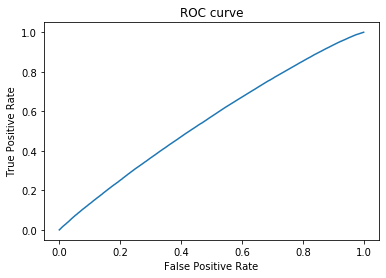

In [289]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_test, y_pred_proba))

In [314]:
#ask about this for the sprint challenge

pd.DataFrame({'False Positive Rate': fpr, 
              'True Positive Rate': tpr, 
              'Threshold': thresholds})

False Positive Rate  True Positive Rate  Threshold
0                 0.000000            0.000000   1.812624
1                 0.000000            0.000008   0.812624
2                 0.000009            0.000008   0.802590
3                 0.000009            0.000025   0.791620
4                 0.000017            0.000025   0.786305
5                 0.000017            0.000033   0.764745
6                 0.000026            0.000033   0.757636
7                 0.000026            0.000050   0.750207
8                 0.000034            0.000050   0.743967
9                 0.000034            0.000084   0.737927
10                0.000052            0.000084   0.737242
11                0.000052            0.000100   0.733601
12                0.000060            0.000109   0.732136
13                0.000060            0.000117   0.731826
14                0.000077            0.000117   0.731142
15                0.000077            0.000125   0.729819
16                0.000103            0.000134   0.728983
17                0.000112            0.000134   0.728483
18                0.000138            0.000167   0.727237
19                0.000163            0.000167   0.722792
20                0.000163            0.000184   0.721413
21                0.000172            0.000184   0.719693
22                0.000172            0.000209   0.717541
23                0.000172            0.000217   0.717345
24                0.000198            0.000217   0.713530
25                0.000198            0.000226   0.711530
26                0.000206            0.000234   0.710556
27                0.000224            0.000234   0.708995
28                0.000224            0.000242   0.708413
29                0.000232            0.000242   0.707210
...                    ...                 ...        ...
70685             0.999544            0.999908   0.199858
70686             0.999544            0.999916   0.198327
70687             0.999587            0.999916   0.191339
70688             0.999604            0.999916   0.189021
70689             0.999604            0.999925   0.186507
70690             0.999613            0.999933   0.186500
70691             0.999639            0.999933   0.183253
70692             0.999656            0.999933   0.179445
70693             0.999656            0.999942   0.179032
70694             0.999673            0.999942   0.178579
70695             0.999716            0.999942   0.168702
70696             0.999716            0.999950   0.167505
70697             0.999742            0.999950   0.164795
70698             0.999751            0.999958   0.163607
70699             0.999794            0.999958   0.155963
70700             0.999794            0.999967   0.155568
70701             0.999811            0.999967   0.154908
70702             0.999845            0.999967   0.150327
70703             0.999845            0.999975   0.149992
70704             0.999862            0.999975   0.145543
70705             0.999862            0.999983   0.143952
70706             0.999880            0.999983   0.142220
70707             0.999888            0.999983   0.141770
70708             0.999914            0.999983   0.140995
70709             0.999923            0.999983   0.138241
70710             0.999948            0.999992   0.134073
70711             0.999966            0.999992   0.126694
70712             0.999966            1.000000   0.115096
70713             0.999983            1.000000   0.082993
70714             1.000000            1.000000   0.052147

[70715 rows x 3 columns]

# Shapley Plots

In [275]:
X_test[features].iloc[[3094]]

duration  release_year  us_popularity_estimate  beat_strength  \
708413  104.120003          2010               99.961753       0.262074   

        bounciness  danceability  dyn_range_mean    energy  flatness  \
708413    0.261804      0.539705        5.520186  0.634578  1.001905   

        instrumentalness  key  liveness  loudness  mechanism   mode  organism  \
708413           0.78785    1   0.20881   -10.071   0.565217  major   0.30744   

        speechiness       tempo   valence  
708413     0.051902  119.995003  0.125579

In [258]:
row = X_test[features].iloc[[3094]]

In [259]:
# STUDY/PRACTICE THIS CELL FOR THE SPRINT CHALLENGE
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

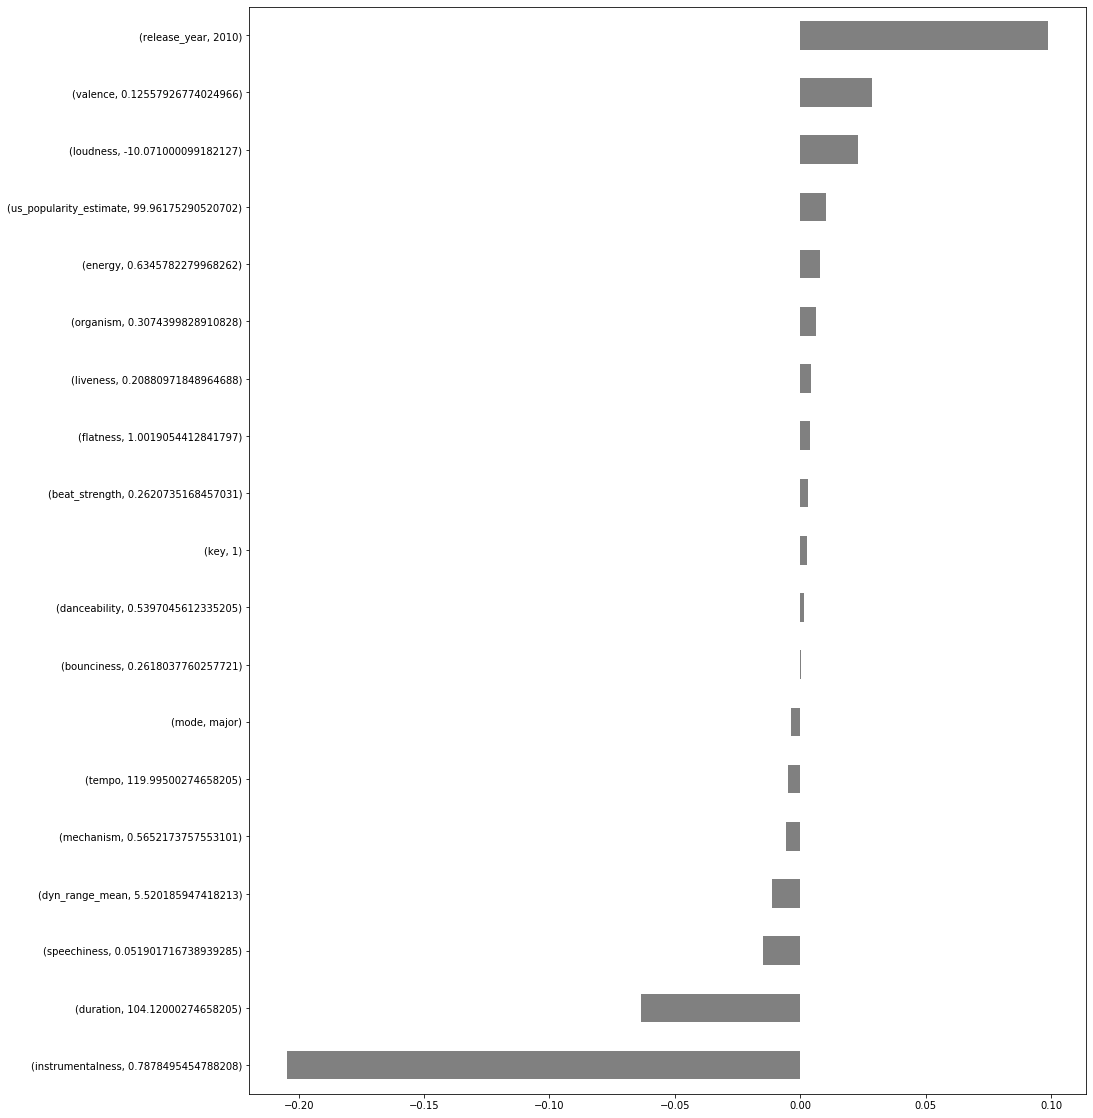

In [274]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));

In [277]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [278]:
print('Top 3 reasons for prediction:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} is {feature_value}.')

print('\n')
print('Cons:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} is {feature_value}.')

Top 3 reasons for prediction:
1. release_year is 2010.
2. valence is 0.12557926774024966.
3. loudness is -10.071000099182127.


Cons:
1. instrumentalness is 0.7878495454788208.
2. duration is 104.12000274658205.
3. speechiness is 0.051901716738939285.


In [299]:
def explain(row_number):
    positive_class = 'Fully Paid'
    positive_class_index = 1
    
    
    # Get & process the data for the row
    row = X_test[features].iloc[[row_number]]
    row_processed = processor.transform(row)
    
    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba
    
    # Show predictiion & probability
    print(f'The model predicts that this track was only played briefly is {pred}, with {pred_proba:.0f}% probability.')
    
    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)
    
    # Get top 3 "pros & cons"
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index
    
    # Show top 3 reasons for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')
    
    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')
    
    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row
    )

    
explain(3099)

The model predicts that this track was only played briefly is False, with 54% probability.


Top 3 reasons for prediction:
1. release_year is 2018.
2. loudness is -6.5980000495910645.
3. speechiness is 0.1265689879655838.


Top counter-argument against prediction:
- tempo is 173.9810028076172.


In [300]:
import pandas_profiling 

profile_report = master_list2.profile_report(check_correlation_pearson= False, correlations={'pearson': False,
                                                                  'spearman': False,
                                                                  'kendall': False,
                                                                  'phi_k': False,
                                                                  'cramers': False,
                                                                  'recoded':False},
                  plot ={'histogram':{'bayesian_blocks_bins': False}})

In [301]:
profile_report

In [313]:
X_train.describe()

# %matplotlib inline
# import seaborn as sns
# sns.distplot(master_list2['loudness']);

duration   release_year  us_popularity_estimate  beat_strength  \
count  755033.000000  755033.000000           755033.000000  755033.000000   
mean      218.934245    2012.940491               99.715355       0.535578   
std        60.646326      10.048336                0.952104       0.162488   
min        30.013330    1950.000000               90.008624       0.000000   
25%       188.013336    2014.000000               99.899449       0.417244   
50%       214.575012    2017.000000               99.986031       0.535453   
75%       242.160004    2018.000000               99.998417       0.650891   
max      1787.760986    2018.000000               99.999997       0.990419   

          bounciness   danceability  dyn_range_mean         energy  \
count  755033.000000  755033.000000   755033.000000  755033.000000   
mean        0.565289       0.656386        8.887944       0.634062   
std         0.181768       0.160615        2.503744       0.181284   
min         0.000000       0.000000        0.000000       0.000000   
25%         0.434810       0.546789        7.002155       0.524472   
50%         0.576769       0.670922        8.713683       0.636002   
75%         0.706172       0.774007       10.513583       0.767345   
max         0.972590       0.988423       32.342781       0.999902   

            flatness  instrumentalness            key       liveness  \
count  755033.000000      7.550330e+05  755033.000000  755033.000000   
mean        1.006118      3.411365e-02       5.122005       0.192435   
std         0.039424      1.473702e-01       3.647054       0.152564   
min         0.000000      0.000000e+00       0.000000       0.000000   
25%         0.986827      6.605354e-09       1.000000       0.100020   
50%         1.012075      8.691476e-07       5.000000       0.128010   
75%         1.032255      1.177820e-04       8.000000       0.240032   
max         1.110550      9.999948e-01      11.000000       1.000000   

            loudness      mechanism       organism    speechiness  \
count  755033.000000  755033.000000  755033.000000  755033.000000   
mean       -7.006955       0.589402       0.352440       0.134870   
std         3.196985       0.214140       0.192562       0.128846   
min       -60.000000       0.000000       0.000000       0.000000   
25%        -8.251000       0.429825       0.201017       0.043225   
50%        -6.431000       0.627778       0.313701       0.079152   
75%        -5.024000       0.761589       0.478764       0.196425   
max         2.625000       1.000000       0.962831       0.964616   

               tempo        valence  
count  755033.000000  755033.000000  
mean      122.132176       0.460445  
std        29.297158       0.228945  
min         0.000000       0.000000  
25%        96.962997       0.276426  
50%       122.250999       0.442084  
75%       144.042007       0.624162  
max       242.317993       0.999990